In [49]:
# Import statements
import os
import traceback
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from LearningSession import *
from LearningChoicePredictor import *
from LearningPsychometricPredictor import *
from sklearn.linear_model import LogisticRegression
import ssm

## Set up Data

In [2]:
animal = 'mSM63'
folder = '/home/chingf/engram/data/musall/learning/neural/mSM63'
dates = os.listdir(folder)
dates.sort()
dates = dates[1:]
dates.sort(key = lambda date: datetime.strptime(date, '%d-%b-%Y')) 

In [3]:
session = LearningSession(
    animal, dates[26], access_engram=True, load_Vc=False
    )

In [74]:
session = pickle.load(
    open("session28.p", "rb")
    )

In [75]:
predictor = LearningPsychometricPredictor(session)

In [76]:
trial_choices = predictor.trial_choices
nonnan_choices = np.logical_not(np.isnan(trial_choices))
nonnan_data = np.ones((nonnan_choices.shape)).astype(bool)
for trial in range(predictor.data.shape[0]):
    if np.sum(np.isnan(predictor.data[trial,:])) > 0:
        nonnan_data[trial] = False
nonnan_indices = np.logical_and(nonnan_choices, nonnan_data)
y = trial_choices[nonnan_indices].astype(int) - 1
y = y.reshape((-1,1))
X = predictor.data[nonnan_indices,:]

In [77]:
indices = np.arange(y.size)
X_train, X_test, y_train, y_test, train_indices, test_indices = \
    train_test_split(
        X, y, indices, test_size = 0.20, stratify=y
        )

In [78]:
K = 4 # Number of states
D = 1 # Dimension of observations

In [79]:
def plot_psychometric(clf, coefs=None):
    oldcoef = clf.coef_
    oldintercept = clf.intercept_
    if not (coefs is None):
        clf.coef_ = np.array([coefs[0,:-1]])
        clf.intercept_ = np.array([coefs[0,-1]])
    data_prevl = []
    data_prevr = []
    for delta in range(-35,36):
        data_prevl.append([0,delta])
        data_prevr.append([1,delta])
    data_prevl = np.array(data_prevl)
    data_prevr = np.array(data_prevr)
    psychometric_curve_prevl = clf.predict_proba(data_prevl)
    psychometric_curve_prevr = clf.predict_proba(data_prevr)
    plt.plot(
        range(-35, 36),
        psychometric_curve_prevl[:,1], color="blue",
        label="Previous Choice Left"
        )
    plt.plot(
        range(-35, 36),
        psychometric_curve_prevr[:,1], color="red",
        label="Previous Choice Right"
        )
    plt.title("Probability of Choosing Right")
    plt.legend()
    plt.xlabel("More Left Beeps >>> More Right Beeps")
    plt.show()
    clf.coef_ = oldcoef
    clf.intercept_ = oldintercept

## GLM HMM

In [80]:
def fit_hmm(
    K, X_train, y_train,
    X_test, y_test, transitions="standard"
    ):
    fitted_lls = []
    best_test_ll = -np.inf
    best_ll_array = None
    best_hmm = None
    input_size = X_train.shape[1]
    for _ in range(15):
        tmp_hmm = ssm.HMM(
            K, D, M=input_size, observations="logistic",
            transitions=transitions,
            observation_kwargs={"input_size":input_size}
            )
        lls = tmp_hmm.fit(
            y_train,
            inputs=X_train,
            method="em"
            )
        test_ll = tmp_hmm.log_likelihood(y_test, inputs=X_test)
        if test_ll > best_test_ll:
            best_test_ll = test_ll
            best_ll_array = lls
            best_hmm = tmp_hmm
    hmm = best_hmm
    lls = best_ll_array
    return hmm, lls, best_test_ll

In [81]:
%%capture
Ks = [1,2,3,4]
K_hmms = []
K_lls = []
K_test_lls = []
for K in Ks:
    _hmm, _lls, _test_ll = fit_hmm(
        K, X_train, y_train,
        X_test, y_test,
        transitions="inputdriven"
        )
    K_hmms.append(_hmm)
    K_lls.append(_lls)
    K_test_lls.append(_test_ll)

Text(0, 0.5, 'Test Set Log Likelihood')

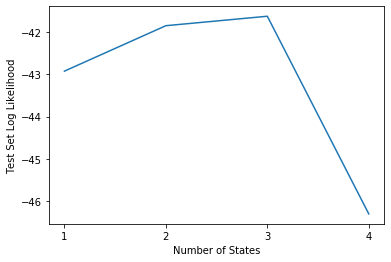

In [82]:
plt.plot(Ks, K_test_lls)
plt.xticks(Ks)
plt.xlabel("Number of States")
plt.ylabel("Test Set Log Likelihood")

In [99]:
hmm = K_hmms[Ks.index(3)]

In [90]:
clf = LogisticRegression().fit(X_train, y_train)

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


m (2, 1)
data (393, 1, 1)
mask (393, 1, 1)
logit_ps (2,1)
data\*logit_ps (393, 2, 1)
lls (393, 2, 1)
np.sum(lls\*mask,axis=-1) (393, 2)

Text(0, 0.5, 'Current Class')

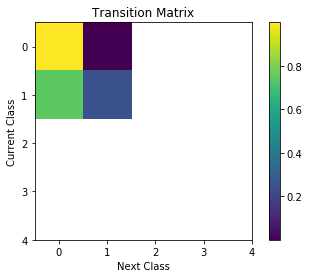

In [61]:
# Plot transition matrix
plt.imshow(hmm.transitions.transition_matrix)
plt.colorbar()
plt.title("Transition Matrix")
plt.xticks(np.arange(K), np.arange(K))
plt.yticks(np.arange(K), np.arange(K))
plt.xlabel("Next Class")
plt.ylabel("Current Class")

In [92]:
def plot_psychometric(clf, coefs=None):
    oldcoef = clf.coef_
    oldintercept = clf.intercept_
    if not (coefs is None):
        clf.coef_ = np.array([coefs[0,:-1]])
        clf.intercept_ = np.array([coefs[0,-1]])
    data_prevl = []
    data_prevr = []
    for delta in range(-35,36):
        data_prevl.append([0,delta])
        data_prevr.append([1,delta])
    data_prevl = np.array(data_prevl)
    data_prevr = np.array(data_prevr)
    psychometric_curve_prevl = clf.predict_proba(data_prevl)
    psychometric_curve_prevr = clf.predict_proba(data_prevr)
    plt.plot(
        range(-35, 36),
        psychometric_curve_prevl[:,1], color="blue",
        label="Previous Choice Left"
        )
    plt.plot(
        range(-35, 36),
        psychometric_curve_prevr[:,1], color="red",
        label="Previous Choice Right"
        )
    plt.title("Probability of Choosing Right")
    plt.legend()
    plt.xlabel("More Left Beeps >>> More Right Beeps")
    plt.show()
    clf.coef_ = oldcoef
    clf.intercept_ = oldintercept

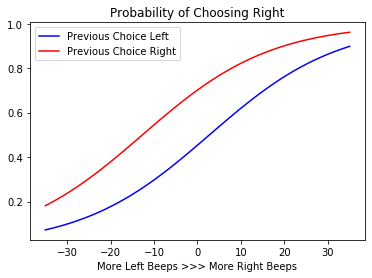

In [91]:
plot_psychometric(clf)

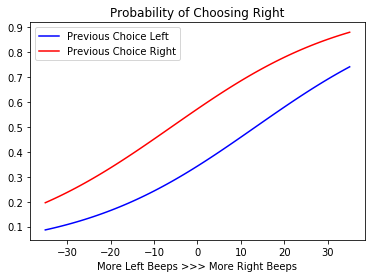

In [103]:
plot_psychometric(clf, hmm.observations.coef[2,:].reshape((1,-1)))

In [107]:
predicted = hmm.most_likely_states(y_test, input=X_test)

In [108]:
predicted

array([2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1,
       1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1])

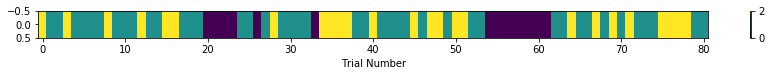

In [106]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    hmm.most_likely_states(y_test, input=X_test).reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.show()

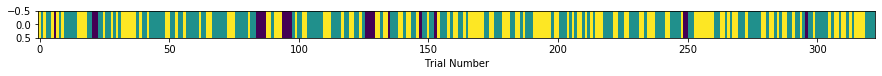

In [105]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    hmm.most_likely_states(y_train, input=X_train).reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.show()